In [2]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [3]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [4]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


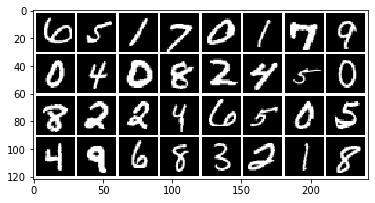

torch.Size([32, 1, 28, 28])


In [5]:
### LOAD DATA ###
dataset = 'mnist'
dataloader, imsize = load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [6]:
def poisson_noise(magn, device, alpha=1):
    intens = magn ** 2
    alpha_2 = alpha ** 2
    lmd = intens / alpha_2
    intens_noise = alpha_2 * torch.distributions.poisson.Poisson(lmd).sample()
    magn_noise = torch.sqrt(intens_noise)
    return magn_noise


def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

# Function to compute test images

def test_generator(model, device, testloader, alpha):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        magn = poisson_noise(calc_mags(data), device, alpha)
        net_input = torch.cat([z, magn], dim=1)
        ouput = model(net_input)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(outputs), np.concatenate(test_images)

In [7]:
### LOAD MODEL ####

model_nr = 4

gen = models.FCNet(imsize=(2, 28, 28), outsize=imsize, h=2048)
#disc = models.FCDiscriminator(imsize=imsize, h=2048)
#disc = models.ConvDiscriminatorSmall(imsize=(2, 28, 28), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/models/cGAN_MNIST/FCGenerator2048MNIST_{}.sd".format(model_nr), map_location={'cuda:1': device.__str__()}));
#disc.load_state_dict(torch.load("../cache/cGAN/ConvDiscriminator64MNIST_{}.sd".format(model_nr), map_location={'cuda:1': device.__str__()}));

Version 0.4


In [8]:
# Calculate test predictions 

alpha = 3.0

test_predicted, test_original = test_generator(gen, device, dataloader['test'], alpha=alpha)
print(test_predicted.shape)

(8000, 1, 28, 28)


In [25]:
### CACHE RESULTS ###

import pickle
pickle.dump(test_original, open("/home/shared/phase-retrieval/test/cGAN_MNIST/cganrand_original_1024_alpha{}.p".format(alpha), "wb"))
pickle.dump(test_predicted, open("/home/shared/phase-retrieval/test/cGAN_MNIST/cganrand_1024_alpha{}.p".format(alpha), "wb"))

In [ ]:
### LOAD RESULTS ###
import pickle

test_original = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_Fashion/cganrand_original_1024_alpha{}.p".format(alpha), "rb"))
test_predicted = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_Fashion/cganrand_1024_alpha{}.p".format(alpha), "rb"))

Original mean 4.489344120025635
Noise mean 3.9442715644836426
Mean Std: 1.4633828
Mean SNR: 3.0545392
1.463 | 3.055 |


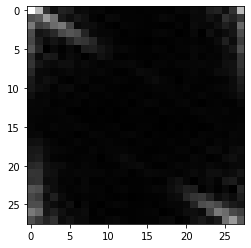

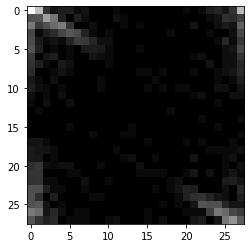

In [9]:
magn = calc_mags(torch.tensor(test_original))
magn_noise = poisson_noise(magn, device, alpha=alpha)

mean_orig = torch.mean(magn).item()
mean_noise = torch.mean(magn_noise).item()
print("Original mean", mean_orig)
print("Noise mean", mean_noise)

means_orig = np.mean(magn.cpu().numpy(), axis=(-1, -2))
errs = magn_noise - magn
stds = np.std(errs.cpu().numpy(), axis=(-1, -2))
print("Mean Std:", np.mean(stds))
print("Mean SNR:", np.mean(means_orig / stds))
print("{:.3f}".format(np.mean(stds)), "|", "{:.3f}".format(np.mean(means_orig / stds)), "|")

plot(magn[0].cpu().numpy() / 70)
plot(magn_noise[0].cpu().numpy() / 70)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


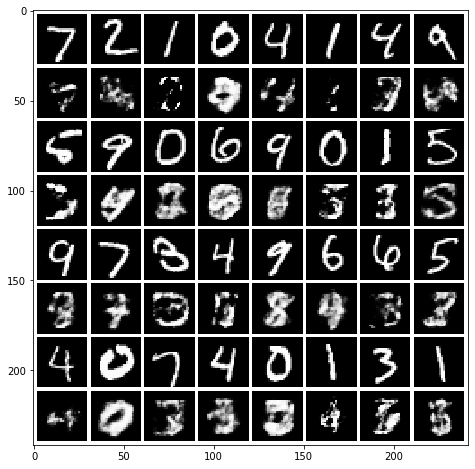

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


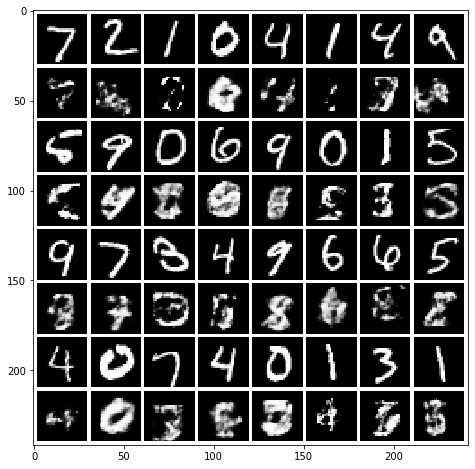

In [218]:
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/cgan/mnist/FCGenerator2048MNIST_{}_alpha{}.png".format(model_nr, alpha))

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/cgan/mnist/FCGenerator2048MNIST_{}_alpha{}_reg.png".format(model_nr, alpha))

In [75]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.05542131216179769, std: 0.04702934124652092
  MAE: 0.08149360173865716, std: 0.05284420938850586
  SSIM: 0.5920675546550709, std: 0.2602153651373603
  Sharpness: 0.11453713952663336, std: 0.0452480140702126
  PhCo-MSE: 0.05283673876829198, std: 0.0475730297161139
  PhCo-MAE: 0.07825864110964176, std: 0.05341380970745156
  PhCo-SSIM: 0.6219725194872752, std: 0.24499062881984904
  CroCo-MSE: 0.04234114237215181, std: 0.035439003551286645
  CroCo-MAE: 0.06708190277822723, std: 0.04143308666097794
  CroCo-SSIM: 0.6654341286934614, std: 0.21253369532827995

Magnitude error:
  MSE Magnitude: 13.712432203505506, std: 13.95493752946309

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.05542 | 0.08149 | 0.5921 | 0.1145 | 0.05284 | 0.07826 | 0.6220 | 0.04234 | 0.06708 | 0.6654 | 13.71 |


## Evaluation for different cGAN models (random z and 1024 samples)

| Nr | alpha | Mean std_noise (magn) | Mean SNR (magn) | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 4 | 0.001 | - | - | 0.05546 | 0.08154 | 0.5919 | 0.1145 | 0.05268 | 0.07812 | 0.6217 | 0.04236 | 0.06712 | 0.6654 | 13.73 |
|
| 4 | 0.01 | 0.005 | 899.165 | 0.02397 | 0.04889 | 0.7973 | 0.09005 | 0.01930 | 0.04296 | 0.8282 | 0.01683 | 0.04000 | 0.8444 | 3.709 |
| 4 | 0.03 | 0.015 | 299.670 | 0.02392 | 0.04883 | 0.7974 | 0.09008 | 0.01909 | 0.04271 | 0.8292 | 0.01682 | 0.03999 | 0.8446 | 3.713 |
| 4 | 0.1 | 0.050 | 89.528 | 0.02393 | 0.04885 | 0.7974 | 0.09010 | 0.01927 | 0.04293 | 0.8279 | 0.01683 | 0.04002 | 0.8444 | 3.714 |
| 4 | 0.3 | 0.154 | 29.178 | 0.02394 | 0.04892 | 0.7971 | 0.09017 | 0.01913 | 0.04283 | 0.8290 | 0.01683 | 0.04008 | 0.8443 | 3.719 |
| 4 | 1.0 | 0.547 | 8.213 | 0.02413 | 0.04985 | 0.7934 | 0.09035 | 0.01937 | 0.04382 | 0.8242 | 0.01696 | 0.04087 | 0.8411 | 3.829 |
| 4 | 3.0 | 1.463 | 3.054 | 0.02569 | 0.05491 | 0.7706 | 0.09446 | 0.02172 | 0.04970 | 0.8002 | 0.01845 | 0.04578 | 0.8211 | 4.662 |
| 4 | 10.0 | 3.229 | 1.387 | 0.03725 | 0.07461 | 0.6585 | 0.1144 | 0.03687 | 0.07355 | 0.6725 | 0.02790 | 0.06334 | 0.7220 | 8.226 |
| 4 | 25.0 | 5.421 | 0.827 | 0.06091 | 0.1043 | 0.4882 | 0.1418 | 0.06634 | 0.1099 | 0.4967 | 0.04759 | 0.08941 | 0.5738 | 14.75 |
| 4 | 50.0 | 7.397 | 0.607 | 0.08553 | 0.1294 | 0.3536 | 0.1648 | 0.09334 | 0.1379 | 0.3807 | 0.06883 | 0.1115 | 0.4620 | 21.28 |


In [7]:
# Latent z optimization

def genopt(sample_magnitudes, gen, disc, device, init_x=None, max_steps=5000, max_loss=0.0, mue=1.0, lr=1.0):
    
    if disc is not None:
        disc.to(device)
        disc.eval()
    gen.to(device)
    gen.eval()
    
    if init_x is None:
        z = torch.randn((sample_magnitudes.shape), requires_grad=True, device=device)
    else:
        raise NotImplementedError
    
    optimizer = optim.Adam([z], lr=lr)
    
    losses = []
    last_out = gen(torch.cat([z, sample_magnitudes], dim=1))
    
    for i in range(max_steps):
        magnitudes = calc_mags(last_out)

        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=(1, 2, 3))
        reconstruction = torch.sum(mse_all)
        #adversarial = -torch.mean(torch.log(disc(torch.cat([last_out, sample_magnitudes], dim=1))))
        #loss = reconstruction + mue * adversarial
        loss = reconstruction + mue * torch.mean(z ** 2)
        
        if loss < max_loss:
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = gen(torch.cat([z, sample_magnitudes], dim=1))
        
        losses.append(loss.item())
    
    return last_out.detach(), losses, mse_all

In [ ]:
### Latent z optimization ###

alphas = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 25.0, 50.0]

for alpha in alphas:

    num_batches = 32
    batch_size = 32
    max_steps = 10000
    max_loss = 0.0
    mue = 0.0
    lr = 1.0

    ###

    out_original = np.zeros((batch_size * num_batches, *imsize))
    out_results = np.zeros((batch_size * num_batches, *imsize))
    mse_all = np.full((batch_size * num_batches), np.inf)

    for batch_i, batch in enumerate(dataloader['test']):
        test_sample = batch.to(device)  
        test_magnitudes = poisson_noise(calc_mags(test_sample), device, alpha)
        out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()


        cur_out_results, cur_loss, cur_mse_all = genopt(sample_magnitudes=test_magnitudes, gen=gen, disc=None, device=device,
                                              max_steps=max_steps, max_loss=max_loss, mue=mue, lr=lr)
        cur_out_results = cur_out_results.cpu().numpy()

        out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
        mse_all[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_mse_all.detach().cpu().numpy()

        print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
        if batch_i + 1 >= num_batches:
            break

    plt.semilogy(cur_loss)
    plt.show()
    
    # down here repeating savings:
    ###############################
    
    import pickle
    pickle.dump(out_original, open("/home/shared/phase-retrieval/test/cGAN_MNIST/cgan_original_1024_alpha{}.p".format(alpha), "wb"))
    pickle.dump(out_results, open("/home/shared/phase-retrieval/test/cGAN_MNIST/cgan_1024_alpha{}.p".format(alpha), "wb"))
    
    # Print predictions #
    to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                        out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
    plot_grid(to_plot, figsize=(8,8),
              file="../out/cgan/mnist/FCGenerator2048MNIST_{}_alpha{}_1024_10000latentSteps.png".format(model_nr, alpha))

    print("Registered:")
    results_reg = register_croco(out_results[:32], out_original[:32])
    to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                        results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
    plot_grid(to_plot, figsize=(8,8),
              file="../out/cgan/mnist/FCGenerator2048MNIST_{}_alpha{}_1024_10000latentSteps_reg.png".format(model_nr, alpha))

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished
Batch 4/32 finished
Batch 5/32 finished
Batch 6/32 finished
Batch 7/32 finished
Batch 8/32 finished
Batch 9/32 finished
Batch 10/32 finished
Batch 11/32 finished
Batch 12/32 finished
Batch 13/32 finished
Batch 14/32 finished
Batch 15/32 finished
Batch 16/32 finished
Batch 17/32 finished
Batch 18/32 finished
Batch 19/32 finished
Batch 20/32 finished
Batch 21/32 finished
Batch 22/32 finished
Batch 23/32 finished
Batch 24/32 finished
Batch 25/32 finished
Batch 26/32 finished
Batch 27/32 finished
Batch 28/32 finished
Batch 29/32 finished
Batch 30/32 finished
Batch 31/32 finished


In [ ]:
### CACHE RESULTS ###

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/cGAN_MNIST/cgan_original_1024_alpha{}.p".format(alpha), "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/cGAN_MNIST/cgan_1024_alpha{}.p".format(alpha), "wb"))

In [34]:
### LOAD RESULTS ###
import pickle

alpha = 50.0

out_original = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_MNIST/cgan_original_1024_alpha{}.p".format(alpha), "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/cGAN_MNIST/cgan_1024_alpha{}.p".format(alpha), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


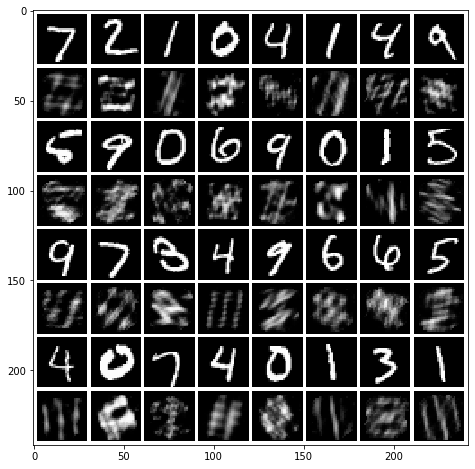

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


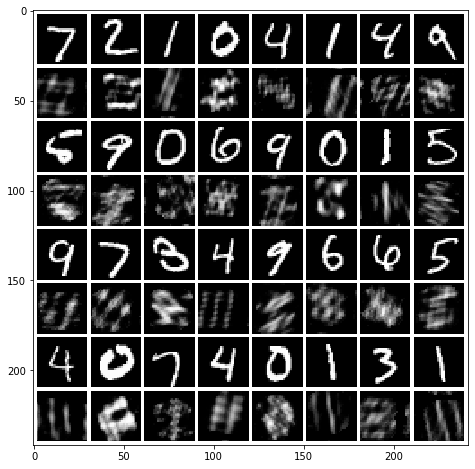

In [35]:
# Print predictions #
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    out_results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8),
          file="../out/cgan/mnist/FCGenerator2048MNIST_{}_alpha{}_1024_10000latentSteps.png".format(model_nr, alpha))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8),
          file="../out/cgan/mnist/FCGenerator2048MNIST_{}_alpha{}_1024_10000latentSteps_reg.png".format(model_nr, alpha))

In [36]:
# Benchmark test predictions #

benchmark(pred=out_results[:1024], true=out_original[:1024], check_all=True)

Signal error:
  MSE: 0.07725255357499039, std: 0.026256005664024976
  MAE: 0.15041161863596322, std: 0.038379656398362674
  SSIM: 0.20599091736090808, std: 0.14818823136720916
  Sharpness: 0.1612203816079622, std: 0.03742773875233449
  PhCo-MSE: 0.08872936222290997, std: 0.04240607344627976
  PhCo-MAE: 0.1644224329290032, std: 0.05567995115102312
  PhCo-SSIM: 0.24504985965551923, std: 0.14289479616097855
  CroCo-MSE: 0.05790578275111044, std: 0.01838092723341782
  CroCo-MAE: 0.12864845873550235, std: 0.03199570139272032
  CroCo-SSIM: 0.36724071731264746, std: 0.10892281936689048

Magnitude error:
  MSE Magnitude: 22.9633182810009, std: 6.294402483739991

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.07725 | 0.1504 | 0.2060 | 0.1612 | 0.08873 | 0.1644 | 0.2450 | 0.05791 | 0.1286 | 0.3672 | 22.96 |


## Final Evaluation (1024 samples)

| Nr | alpha | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 4 | 0.01 | 0.02260 | 0.03804 | 0.8297 | 0.01068 | 0.001312 | 0.004727 | 0.9873 | 0.001085 | 0.004447 | 0.9890 | 0.03169 |
| 4 | 0.03 | 0.02220 | 0.03730 | 0.8330 | 0.01036 | 0.001133 | 0.004462 | 0.9891 | 0.0009650 | 0.004265 | 0.9903 | 0.03152 |
| 4 | 0.1 | 0.02219 | 0.03751 | 0.8333 | 0.01095 | 0.001293 | 0.004777 | 0.9879 | 0.001125 | 0.004563 | 0.9891 | 0.03206 |
| 4 | 0.3 | 0.02214 | 0.03742 | 0.8334 | 0.01167 | 0.001406 | 0.005199 | 0.9872 | 0.001083 | 0.004819 | 0.9892 | 0.03443 |
| 4 | 1.0 | 0.02284 | 0.04019 | 0.8255 | 0.01900 | 0.001515 | 0.007696 | 0.9835 | 0.001265 | 0.007397 | 0.9851 | 0.08228 |
| 4 | 3.0 | 0.02294 | 0.04629 | 0.8039 | 0.04698 | 0.003920 | 0.01913 | 0.9436 | 0.003693 | 0.01884 | 0.9450 | 0.5704 |
| 4 | 10.0 | 0.03555 | 0.07624 | 0.6180 | 0.1037 | 0.02059 | 0.05727 | 0.7269 | 0.01792 | 0.05385 | 0.7435 | 3.973 |
| 4 | 25.0 | 0.06151 | 0.1227 | 0.3536 | 0.1463 | 0.06415 | 0.1255 | 0.4084 | 0.04202 | 0.09987 | 0.5060 | 12.32 |
| 4 | 50.0 | 0.07725 | 0.1504 | 0.2060 | 0.1612 | 0.08873 | 0.1644 | 0.2450 | 0.05791 | 0.1286 | 0.3672 | 22.96 |

## Evaluation for different z optimizations (32 samples)

| Nr | alpha | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 4 | 0.01 | 0.02597 | 0.04398 | 0.8101 | 0.007014 | 0.0002691 | 0.002969 | 0.9965 | 0.0001958 | 0.002786 | 0.9974 | 0.01174 |
| 4 | 0.03 | 0.02548 | 0.04262 | 0.8158 | 0.007404 | 0.0003113 | 0.003007 | 0.9961 | 0.0002894 | 0.003003 | 0.9959 | 0.01560 |
| 4 | 0.1 | 0.02501 | 0.04228 | 0.8148 | 0.007657 | 0.0004441 | 0.003135 | 0.9952 | 0.0003923 | 0.003084 | 0.9953 | 0.01302 |
| 4 | 0.3 | 0.02432 | 0.04151 | 0.8221 | 0.009013 | 0.0003487 | 0.003572 | 0.9961 | 0.0003487 | 0.003572 | 0.9961 | 0.02060 |
| 4 | 1.0 | 0.02531 | 0.04400 | 0.8142 | 0.01611 | 0.0005187 | 0.005951 | 0.9932 | 0.0005187 | 0.005951 | 0.9932 | 0.06890 |
| 4 | 3.0 | 0.02143 | 0.04568 | 0.8138 | 0.04836 | 0.003865 | 0.01964 | 0.9449 | 0.003865 | 0.01964 | 0.9449 | 0.5840 |
| 4 | 10.0 | 0.03198 | 0.07200 | 0.6280 | 0.1040 | 0.02066 | 0.05668 | 0.7228 | 0.01747 | 0.05292 | 0.7412 | 3.774 |
| 4 | 25.0 | 0.06171 | 0.1216 | 0.3334 | 0.1413 | 0.05635 | 0.1155 | 0.4420 | 0.04022 | 0.09614 | 0.5207 | 11.96 |
| 4 | 50.0 | 0.07363 | 0.1455 | 0.2091 | 0.1597 | 0.08682 | 0.1608 | 0.2422 | 0.05857 | 0.1281 | 0.3419 | 23.75 |